# 6.6. 卷积神经网络（LeNet）
## 6.6.1. LeNet

In [2]:
import torch
import torch.nn

net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5, padding=2),
    torch.nn.Sigmoid(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(6, 16, kernel_size=5),
    torch.nn.Sigmoid(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 5 * 5, 120),
    torch.nn.Sigmoid(),
    torch.nn.Linear(120, 84),
    torch.nn.Sigmoid(),
    torch.nn.Linear(84, 10)
)

In [3]:
X = torch.rand((1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape:\t", X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


## 6.6.2. 模型训练

In [4]:
import sys
sys.path.append('..')

import helper

batch_size = 256
train_iter, test_iter = helper.load_data_fashion_mnist(batch_size, path = "../data/")

由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中。

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device = None):
    '''使用GPU计算操作模型在数据集上的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval() # 切换评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = helper.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(helper.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [6]:
import torch.optim

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    '''用GPU训练模型'''
    def init_weight(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    print('train on ', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr)
    loss = torch.nn.CrossEntropyLoss()
    animator = helper.Animator(xlabel='epochs', xlim = [1, num_epochs],
                                legend=['train_loss', 'train_acc', 'test_acc'])
    timer, num_batchs = helper.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = helper.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():       # 不更新梯度
                metric.add(l * X.shape[0], helper.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batchs // 5) == 0 or i == num_batchs - 1:
                animator.add(epoch + (i + 1) / num_batchs, train_l)
                animator.add(epoch + (i + 1) / num_batchs, train_acc)
            test_acc = evaluate_accuracy_gpu(net, test_iter)
            animator.add(epoch + 1, test_acc)
        print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
        print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')
    animator.show()

train on  cuda:0


..\helper.py:71: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  self.axes.set_xlim(xlim)


loss 2.322, train acc 0.100, test acc 0.100
1678.1 examples/sec on cuda:0


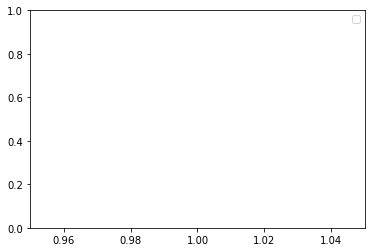

In [7]:
lr, num_epochs = 0.9, 1
# 79m 5.9s(CPU更慢)
train_ch6(net, train_iter, test_iter, num_epochs, lr, helper.GPU.try_gpu())